In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import time

In [2]:
with open('./data/lab1/kroB100.txt') as f:
    data = f.read()
data = data.split('\n')
data = pd.DataFrame([i.split(' ') for i in data])
data = data.drop(0, axis=1)
data = data.drop(100, axis=0)

print(data.head())

      1     2
0  1380   939
1  2848    96
2  3510  1671
3   457   334
4  3888   666


In [3]:
def distance(a, b):
    return round(np.sqrt(( a[0] - b[0])**2 + (a[1]) - b[1])**2)

def calc_distance_sum(cycle, distance_matrix):
    suma = 0
    for i in range(1, len(cycle)):
        suma += distance_matrix[cycle[i-1], cycle[i]]
    return suma

points_matrix = data.to_numpy()
matrix = []
for i in range(100):
    matrix.append([])
    for j in range(100):
        matrix[i].append(points_matrix[i,:].astype(int) - points_matrix[j,:].astype(int))
matrix = np.array(matrix)

distance_matrix = np.sqrt(np.square(matrix[:,:,0]) + np.square(matrix[:,:,1]))
distance_matrix.shape

for i in range(distance_matrix.shape[0]):
    distance_matrix[i,i] = np.inf

In [39]:
def plot_results(cycles, points_matrix):
    plt.scatter(points_matrix[..., 0], points_matrix[..., 1])
    plt.plot(points_matrix[cycles[0], 0], points_matrix[cycles[0], 1], 'r')
    plt.plot(points_matrix[cycles[1], 0], points_matrix[cycles[1], 1], 'g')
    plt.show()

def plot_results2(cycles, cycles2, points_matrix):
    plt.scatter(points_matrix[..., 0], points_matrix[..., 1])
    plt.plot(points_matrix[cycles[1], 0], points_matrix[cycles[1], 1], 'g')
    plt.plot(points_matrix[cycles[0], 0], points_matrix[cycles[0], 1], 'r')

    plt.plot(points_matrix[cycles2[1], 0], points_matrix[cycles2[1], 1], 'b')
    plt.plot(points_matrix[cycles2[0], 0], points_matrix[cycles2[0], 1], 'orange')

    plt.show()

In [5]:
def solve_cycle(distance_matrix, start = -1):
    remaining = [i for i in range(distance_matrix.shape[0])]
    if start == -1:
        x = np.random.choice(remaining)
    else:
        x = start
    first_cycle = [x]
    remaining.remove(x)
    ind = np.argpartition(distance_matrix[x,:], -2)[-2:]
    second_x = ind.tolist()
    second_x.remove(x)
    second_x = second_x[0]
    second_cycle = [second_x]
    remaining.remove(second_x)

    cycles = [first_cycle, second_cycle]

    for cycle in cycles:
        min_node = remaining[np.argmin(distance_matrix[cycle[-1]][remaining])]
        cycle.append(min_node)
        remaining.remove(min_node)

    while remaining:
        for cycle in cycles:
            cycle.append(cycle[0])
            best_node = None
            lowest_distance_increase = np.inf
            best_index = None

            for i in range(len(cycle) - 1):
                for remaining_node in remaining:
                    distance_increase = distance_matrix[cycle[i]][remaining_node] + distance_matrix[remaining_node][cycle[i+1]] - distance_matrix[cycle[i]][cycle[i+1]]
                    if distance_increase < lowest_distance_increase:
                        lowest_distance_increase = distance_increase
                        best_node = remaining_node
                        best_index = i

            cycle.insert(best_index + 1, best_node)
            # plot_results(cycles)
            remaining.remove(best_node)
            cycle.pop()

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

def solve_random(distance_matrix):
    remaining = [i for i in range(distance_matrix.shape[0])]
    cycles = [[], []]
    append_to_cycle = 0
    while len(remaining) > 0:
        x = np.random.choice(remaining)
        cycles[append_to_cycle].append(x)
        remaining.remove(x)
        append_to_cycle = 1 - append_to_cycle

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

29136.692730989635


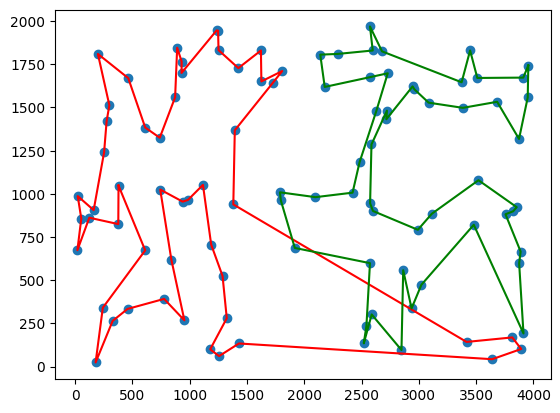

In [6]:
cycles = solve_cycle(distance_matrix)
print(calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix))
plot_results(cycles)

Lowest distance = 26308.885271151106


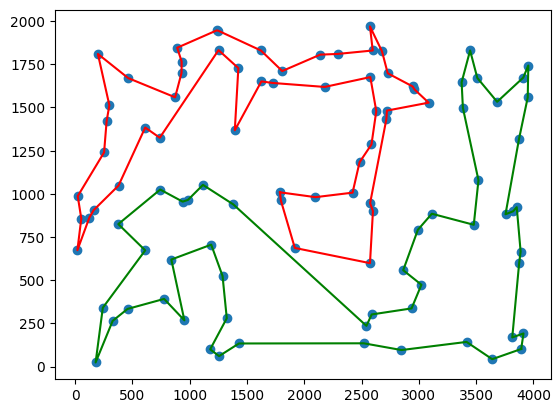

In [7]:
lowest_distance = np.inf
highest_distance = 0
sum_distance = 0
for start in range(100):
    cycles = solve_cycle(distance_matrix)
    distance = calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix)
    lowest_distance = min(lowest_distance, distance)
    if lowest_distance == distance:
        best_cycles = [x.copy() for x in cycles]
print(f"Lowest distance = {lowest_distance}")
plot_results(best_cycles)

In [8]:
def shuffled_outside_swap_candidates(paths):
    arr = [[x,y] for x in range(len(paths[0])) for y in range(len(paths[1]))]
    random.shuffle(arr)
    return arr

def shuffled_inside_swap_candidates(path):
    arr = []
    for i in range(len(path)):
        for j in range(i+1, len(path) - 1):
            arr.append([i,j])
    random.shuffle(arr)
    return arr

def swap_vertice_cost(distance_matrix, path, index, new_city):
    path_length = len(path)
    previous = path[(index-1) % path_length]
    current = path[index]
    next = path[(index+1) % path_length]
    return distance_matrix[previous, new_city] + distance_matrix[new_city, next] - distance_matrix[previous, current] - distance_matrix[current, next]

def swap_vertice_outside_cost(distance_matrix, paths, i, j):
    return swap_vertice_cost(distance_matrix, paths[0], i, paths[1][j]) + swap_vertice_cost(distance_matrix, paths[1], j, paths[0][i])

def swap_vertice_inside_cost(distance_matrix, path, i, j): # can only use candidates from shuffled_inside_swap_candidates function
    path_length = len(path)
    previous1 = path[(i-1) % path_length]
    current1 = path[i]
    next1 = path[(i+1) % path_length]
    previous2 = path[(j-1) % path_length]
    current2 = path[j]
    next2 = path[(j+1) % path_length]
    if abs(i-j) == 1: # because if they are neighbours they can become each other next vertex in path, we also dont include distance between them in equation because it would be reduced anyway
        return distance_matrix[previous1, current2] + distance_matrix[current1, next2] - distance_matrix[previous1, current1] - distance_matrix[current2, next2]
    if i in [0, path_length-1] and j in [0, path_length-1]:
        return distance_matrix[current2, next1] + distance_matrix[previous2, current1] - distance_matrix[current1, next1] - distance_matrix[previous2, current2]
    else:
        new_distance = distance_matrix[previous1, current2] + distance_matrix[current2, next1] + distance_matrix[previous2, current1] + distance_matrix[current1, next2]
        old_distance = distance_matrix[previous1, current1] + distance_matrix[current1, next1] + distance_matrix[previous2, current2] + distance_matrix[current2, next2]
        return new_distance - old_distance

def swap_edge_inside_cost(distance_matrix, path, i, j):
    if i == 0 and j == len(path) - 2:
        return 0
    path_length = len(path)
    previous1 = path[(i-1) % path_length]
    current1 = path[i]
    current2 = path[j]
    next2 = path[(j+1) % path_length]
    return distance_matrix[previous1, current2] + distance_matrix[current1, next2] - distance_matrix[previous1, current1] - distance_matrix[current2, next2]

def swap_vertice_outside(paths, i, j):
    k = paths[1][j]
    paths[1][j] = paths[0][i]
    paths[0][i] = k

def swap_vertice_inside(path, i, j):
    k = path[j]
    path[j] = path[i]
    path[i] = k

def swap_edges_inside(path, i, j):
    path[i:j+1] = reversed(path[i:j+1])

def solve_greedy(distance_matrix, initial_cycles, neighborhood='vertex'):
    cycles = copy.deepcopy(initial_cycles)
    cycles[0].pop()
    cycles[1].pop()
    outside_checked = False
    inside_checked = False
    if neighborhood == 'vertex':
        while not (outside_checked and inside_checked):
            new_change_found = False
            if (not outside_checked and inside_checked) or (not outside_checked and np.random.random() < 0.5):
                outside_swap_candidates = shuffled_outside_swap_candidates(cycles)
                for candidates in outside_swap_candidates:
                    delta = swap_vertice_outside_cost(distance_matrix, cycles, candidates[0], candidates[1])
                    if delta < 0:
                        swap_vertice_outside(cycles, candidates[0], candidates[1])
                        change_delta = delta
                        swap_candidates = candidates.copy()
                        new_change_found = True
                        action = "vertice outside"
                        break
                if new_change_found:
                    # print(f" swap candidates = {swap_candidates} delta = {change_delta} swap = {action}")
                    outside_checked = False
                    inside_checked = False
                    continue
                outside_checked = True
            if not inside_checked:
                order = np.arange(len(cycles))
                np.random.shuffle(order)
                for i in order:
                    inside_swap_candidates = shuffled_inside_swap_candidates(cycles[i])
                    for candidates in inside_swap_candidates:
                        delta = swap_vertice_inside_cost(distance_matrix, cycles[i], candidates[0], candidates[1])
                        if delta < 0:
                            swap_vertice_inside(cycles[i], candidates[0], candidates[1])
                            change_delta = delta
                            swap_candidates = candidates.copy()
                            new_change_found = True
                            action = "vertice inside"
                            break
                if new_change_found:
                    # print(f" swap candidates = {swap_candidates} delta = {change_delta} swap = {action}")
                    outside_checked = False
                    inside_checked = False
                    continue
                inside_checked = True
    else:
        while not inside_checked:
            i = np.random.choice(np.arange(len(cycles)))
            inside_swap_candidates = shuffled_inside_swap_candidates(cycles[i])
            for candidates in inside_swap_candidates:
                delta = swap_edge_inside_cost(distance_matrix, cycles[i], candidates[0], candidates[1])
                if delta < 0:
                    swap_edges_inside(cycles[i], candidates[0], candidates[1])
                    # plot_results(cycles)
                    change_delta = delta
                    swap_candidates = candidates.copy()
                    inside_checked = True
                    action ="edge inside"
                    break
            if inside_checked:
                # print(f" swap candidates = {swap_candidates} delta = {change_delta} swap = {action}")
                inside_checked = False
                continue
            inside_checked = True

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

def solve_steepest(distance_matrix, initial_cycles, neighborhood='vertex'):
    cycles = copy.deepcopy(initial_cycles)
    cycles[0].pop()
    cycles[1].pop()

    new_change_found = True
    best_candidates = None
    is_change_outside = None
    best_cycle_index = 0
    if neighborhood == 'vertex':
        while new_change_found:
            new_change_found = False
            best_delta = np.inf
            outside_swap_candidates = shuffled_outside_swap_candidates(cycles)
            for candidates in outside_swap_candidates:
                delta = swap_vertice_outside_cost(distance_matrix, cycles, candidates[0], candidates[1])
                if delta < 0 and delta < best_delta:
                    best_candidates = [candidates[0], candidates[1]]
                    is_change_outside = True
                    new_change_found = True

            for i in range(len(cycles)):
                inside_swap_candidates = shuffled_inside_swap_candidates(cycles[i])
                for candidates in inside_swap_candidates:
                    delta = swap_vertice_inside_cost(distance_matrix, cycles[i], candidates[0], candidates[1])
                    if delta < 0 and delta < best_delta:
                        best_candidates = [candidates[0], candidates[1]]
                        best_cycle_index = i
                        is_change_outside = False
                        new_change_found = True

            if new_change_found:
                if is_change_outside:
                    swap_vertice_outside(cycles, best_candidates[0], best_candidates[1])
                else:
                    swap_vertice_inside(cycles[best_cycle_index], best_candidates[0], best_candidates[1])

    else:
        while new_change_found:
            new_change_found = False
            best_delta = np.inf
            i = np.random.choice(np.arange(len(cycles)))
            inside_swap_candidates = shuffled_inside_swap_candidates(cycles[i])
            for candidates in inside_swap_candidates:
                delta = swap_edge_inside_cost(distance_matrix, cycles[i], candidates[0], candidates[1])
                if delta < 0 and delta < best_delta:
                    best_delta = delta
                    best_cycle_index = i
                    best_candidates = [candidates[0], candidates[1]]
                    new_change_found = True
            if new_change_found:
                swap_edges_inside(cycles[best_cycle_index], best_candidates[0], best_candidates[1])

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

distance = 26869.31413579137
distance = 26235.594619566255	 633.7195162251155
distance = 25603.362729570894	 1265.9514062204762


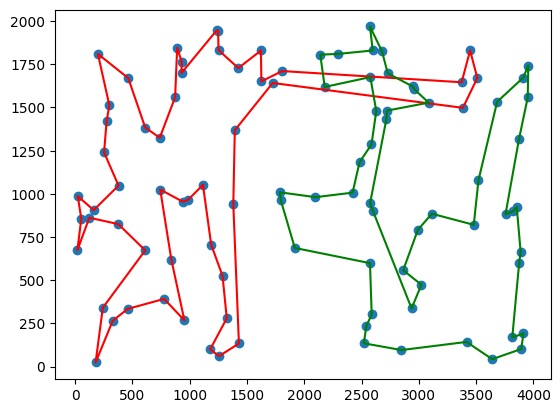

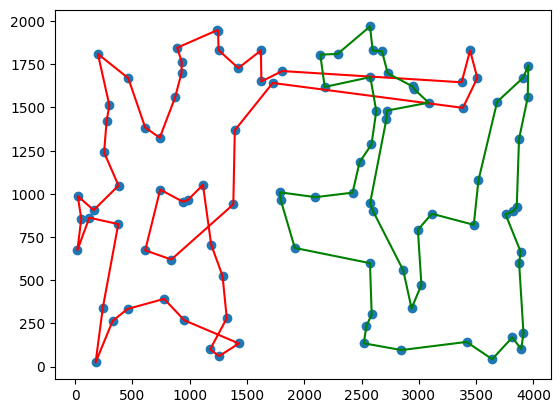

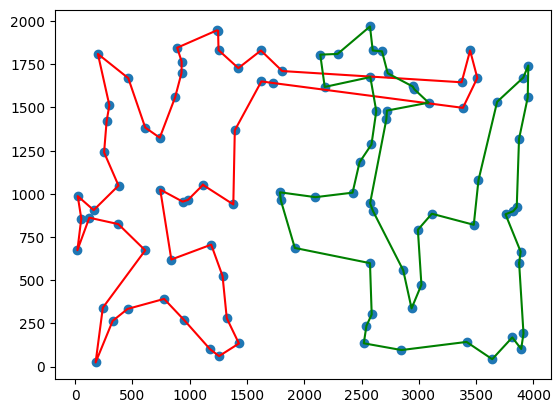

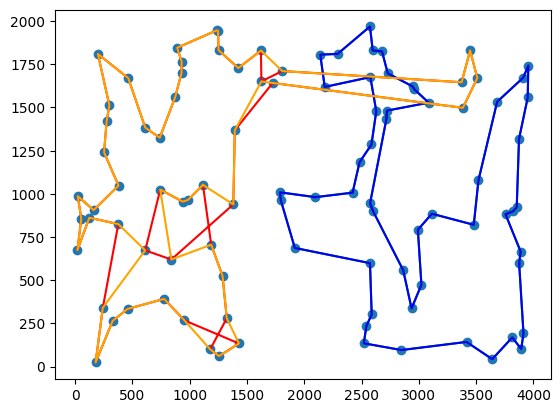

In [30]:
initial_cycles = solve_cycle(distance_matrix)
new_cycles = solve_greedy(distance_matrix, initial_cycles, 'vertex2')
steepest_cycles = solve_steepest(distance_matrix, initial_cycles, 'vertex2')

distance1 = calc_distance_sum(initial_cycles[0], distance_matrix) + calc_distance_sum(initial_cycles[1], distance_matrix)
print(f"distance = {distance1}")

distance2 = calc_distance_sum(new_cycles[0], distance_matrix) + calc_distance_sum(new_cycles[1], distance_matrix)
print(f"distance = {distance2}\t {distance1-distance2}")

distance3 = calc_distance_sum(steepest_cycles[0], distance_matrix) + calc_distance_sum(steepest_cycles[1], distance_matrix)
print(f"distance = {distance3}\t {distance1-distance3}")

plot_results(initial_cycles)
plot_results(new_cycles)
plot_results(steepest_cycles)
plot_results2(new_cycles, steepest_cycles)

In [45]:
instances = ['./data/lab1/kroA100.txt', './data/lab1/kroB100.txt']
neighborhoods = ['vertex', 'edge']
strategies = [solve_greedy, solve_steepest]
starting_options = ['random', 'cycle']

def get_results():
    results = []
    times = []
    for instance in instances:
        with open(instance) as f:
            data = f.read()
        data = data.split('\n')
        data = pd.DataFrame([i.split(' ') for i in data])
        data = data.drop(0, axis=1)
        data = data.drop(100, axis=0)

        points_matrix = data.to_numpy()
        points_matrix = points_matrix.astype(int)
        matrix = []
        for i in range(100):
            matrix.append([])
            for j in range(100):
                matrix[i].append(points_matrix[i, :] - points_matrix[j, :])
        matrix = np.array(matrix)
        distance_matrix = np.sqrt(np.square(matrix[:, :, 0]) + np.square(matrix[:, :, 1]))

        for i in range(distance_matrix.shape[0]):
            distance_matrix[i, i] = np.inf

        for strategy in strategies:
            for neighborhood in neighborhoods:
                for starting_option in starting_options:
                    distances = []
                    algorithm_times = []
                    best_cycles = None
                    best_distance = np.inf
                    for i in range(distance_matrix.shape[0]):
                        if starting_option == 'random':
                            starting_cycles = solve_random(distance_matrix)
                        else:
                            starting_cycles = solve_cycle(distance_matrix, start=i)
                        start_time = time.time()
                        cycles = strategy(distance_matrix, starting_cycles, neighborhood)
                        algorithm_times.append(time.time() - start_time)
                        distances.append(calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix))
                        if distances[-1] < best_distance:
                            best_distance = distances[-1]
                            best_cycles = copy.deepcopy(cycles)
                    times.append(dict(instance=instance, strategy=strategy.__name__, neighborhood=neighborhood, starting_option=starting_option, min_time=min(algorithm_times), mean_time=np.mean(algorithm_times), max_time=max(algorithm_times)))
                    results.append(dict(instance=instance, strategy=strategy.__name__, neighborhood=neighborhood, starting_option=starting_option, min_distance=min(distances), mean_distance=np.mean(distances), max_distance=max(distances)))
                    print(f'Intance: {instance}, strategy: {strategy.__name__}, neighborhood: {neighborhood}, starting_option: {starting_option}, best_distance: {best_distance}')
                    plot_results(best_cycles, points_matrix)
    return results, times

Intance: ./data/lab1/kroA100.txt, strategy: solve_greedy, neighborhood: vertex, starting_option: random, best_distance: 34895.048190323614


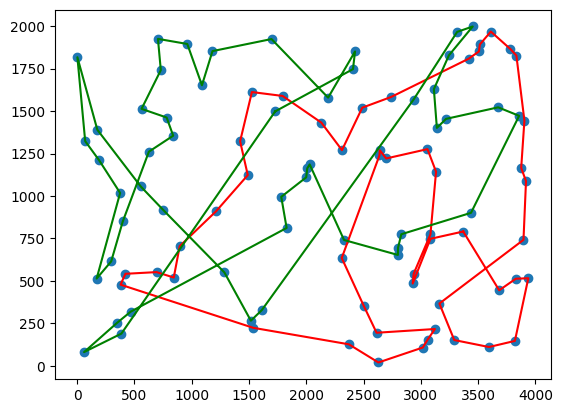

Intance: ./data/lab1/kroA100.txt, strategy: solve_greedy, neighborhood: vertex, starting_option: cycle, best_distance: 24816.944802228463


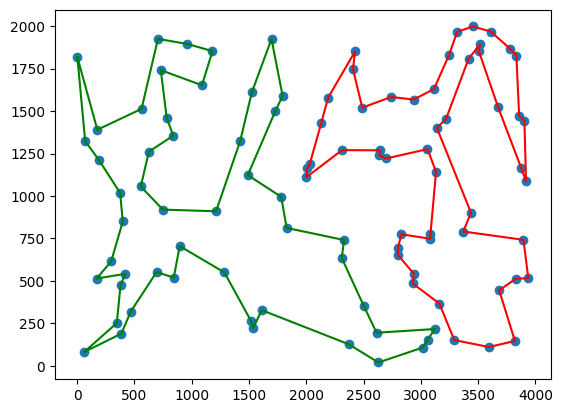

Intance: ./data/lab1/kroA100.txt, strategy: solve_greedy, neighborhood: edge, starting_option: random, best_distance: 33478.23590348948


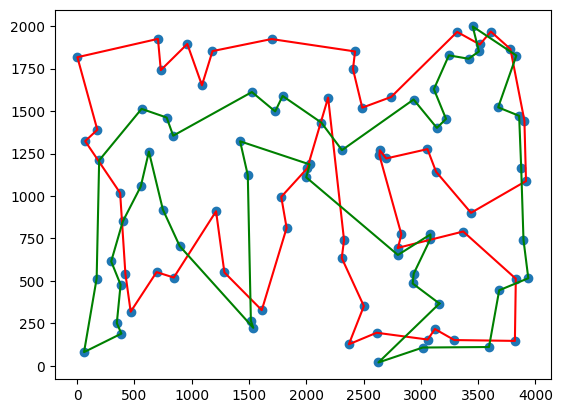

Intance: ./data/lab1/kroA100.txt, strategy: solve_greedy, neighborhood: edge, starting_option: cycle, best_distance: 25797.6040173648


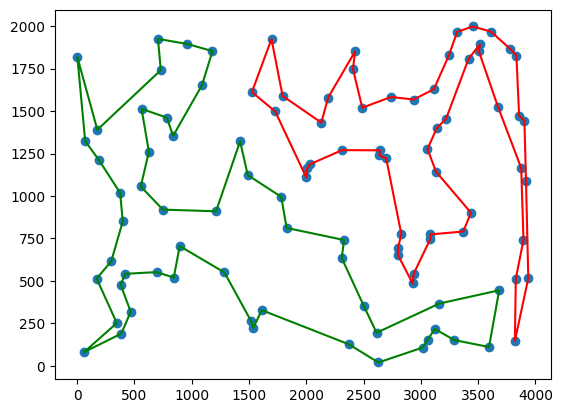

Intance: ./data/lab1/kroA100.txt, strategy: solve_steepest, neighborhood: vertex, starting_option: random, best_distance: 32480.9090607877


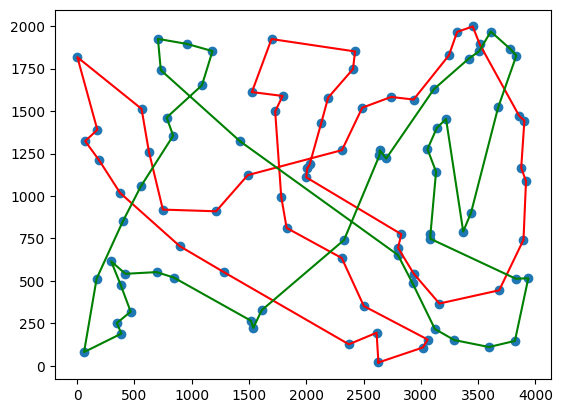

Intance: ./data/lab1/kroA100.txt, strategy: solve_steepest, neighborhood: vertex, starting_option: cycle, best_distance: 24130.176300762178


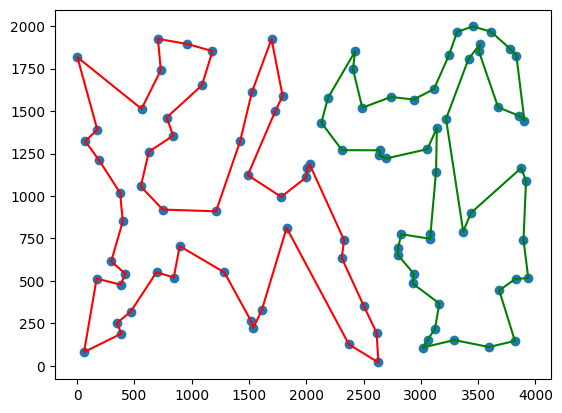

Intance: ./data/lab1/kroA100.txt, strategy: solve_steepest, neighborhood: edge, starting_option: random, best_distance: 32620.992939730044


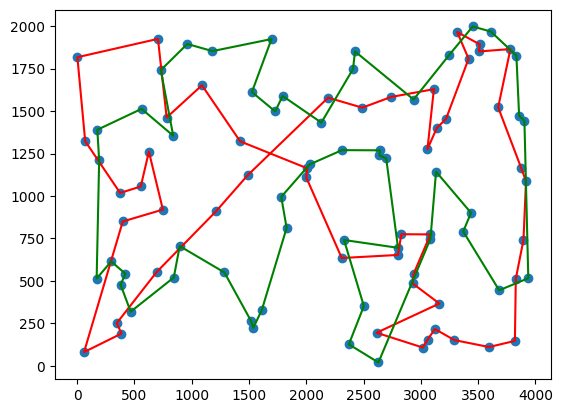

Intance: ./data/lab1/kroA100.txt, strategy: solve_steepest, neighborhood: edge, starting_option: cycle, best_distance: 25266.671541977175


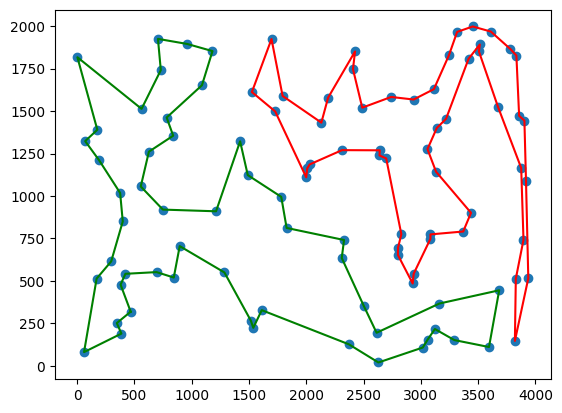

Intance: ./data/lab1/kroB100.txt, strategy: solve_greedy, neighborhood: vertex, starting_option: random, best_distance: 33135.09805758355


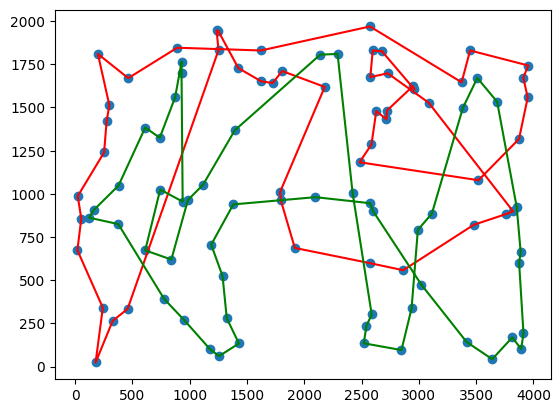

Intance: ./data/lab1/kroB100.txt, strategy: solve_greedy, neighborhood: vertex, starting_option: cycle, best_distance: 23544.263339358804


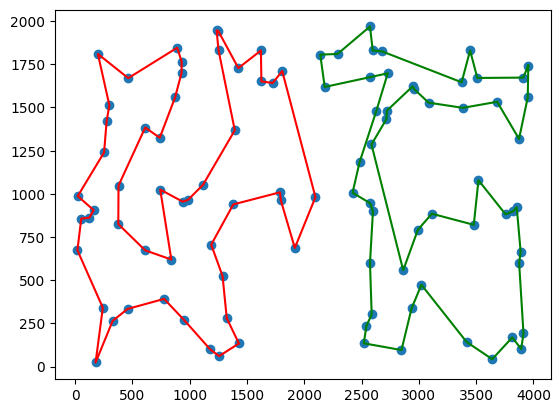

Intance: ./data/lab1/kroB100.txt, strategy: solve_greedy, neighborhood: edge, starting_option: random, best_distance: 33080.71154052945


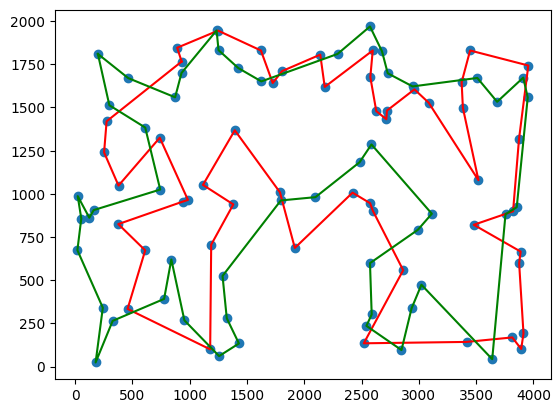

Intance: ./data/lab1/kroB100.txt, strategy: solve_greedy, neighborhood: edge, starting_option: cycle, best_distance: 25683.947101617352


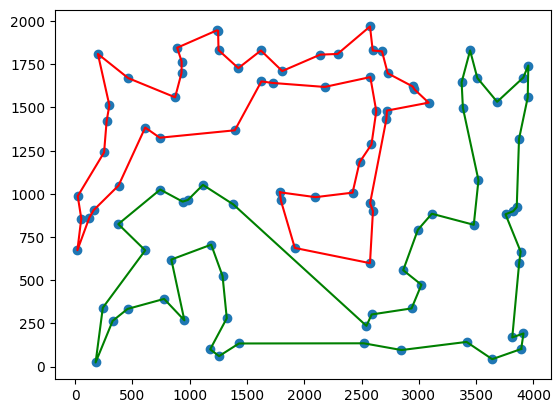

Intance: ./data/lab1/kroB100.txt, strategy: solve_steepest, neighborhood: vertex, starting_option: random, best_distance: 35428.82173663038


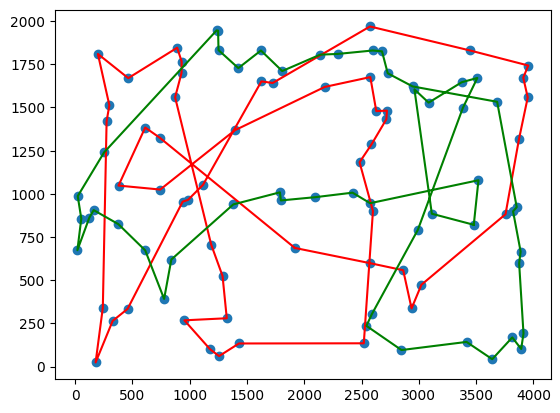

Intance: ./data/lab1/kroB100.txt, strategy: solve_steepest, neighborhood: vertex, starting_option: cycle, best_distance: 25575.416932130902


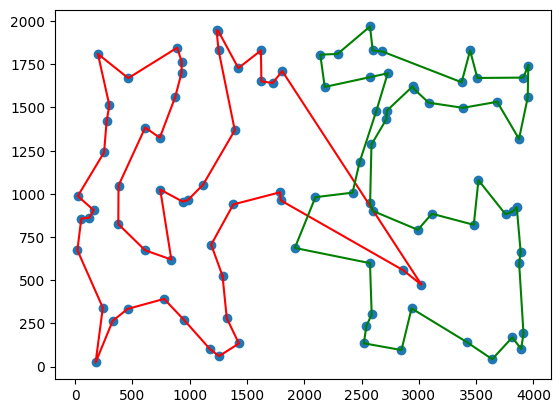

Intance: ./data/lab1/kroB100.txt, strategy: solve_steepest, neighborhood: edge, starting_option: random, best_distance: 31166.481789527737


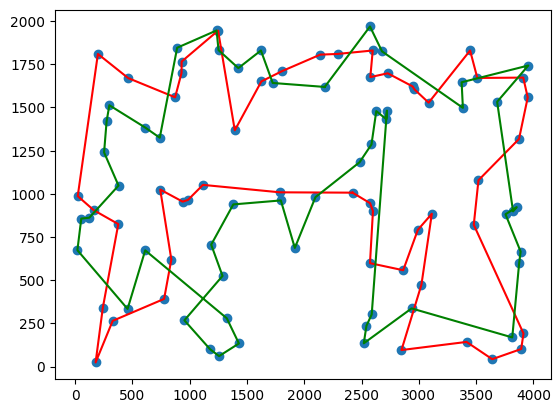

Intance: ./data/lab1/kroB100.txt, strategy: solve_steepest, neighborhood: edge, starting_option: cycle, best_distance: 25689.14618588607


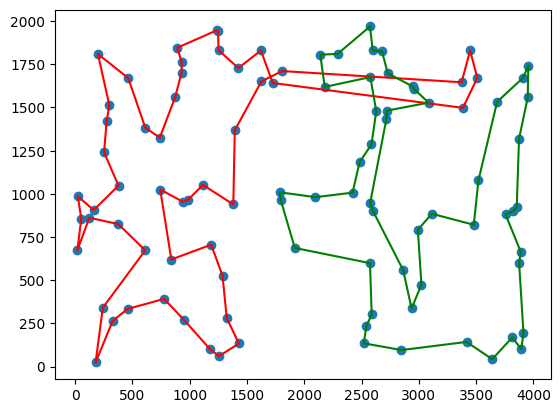

In [46]:
results, times = get_results()

In [53]:
pd.DataFrame(results)

,instance,strategy,neighborhood,starting_option,min_distance,mean_distance,max_distance
0,./data/lab1/kroA100.txt,solve_greedy,vertex,random,34895.048190,42032.021701,50799.917622
1,./data/lab1/kroA100.txt,solve_greedy,vertex,cycle,24816.944802,26856.775828,28705.195202
2,./data/lab1/kroA100.txt,solve_greedy,edge,random,33478.235903,38205.962107,47945.539878
3,./data/lab1/kroA100.txt,solve_greedy,edge,cycle,25797.604017,27450.342730,29461.237384
4,./data/lab1/kroA100.txt,solve_steepest,vertex,random,32480.909061,42212.757226,49567.892239
5,./data/lab1/kroA100.txt,solve_steepest,vertex,cycle,24130.176301,26901.522416,28820.989704
6,./data/lab1/kroA100.txt,solve_steepest,edge,random,32620.992940,35429.882006,42782.963392
7,./data/lab1/kroA100.txt,solve_steepest,edge,cycle,25266.671542,27201.034386,29102.778346
8,./data/lab1/kroB100.txt,solve_greedy,vertex,random,33135.098058,41733.155528,48562.638083
9,./data/lab1/kroB100.txt,solve_greedy,vertex,cycle,23544.263339,26833.999398,28183.468042


In [51]:
pd.DataFrame(times)

,instance,strategy,neighborhood,starting_option,min_time,mean_time,max_time
0,./data/lab1/kroA100.txt,solve_greedy,vertex,random,0.304640,0.572758,0.842238
1,./data/lab1/kroA100.txt,solve_greedy,vertex,cycle,0.015632,0.078679,0.190998
2,./data/lab1/kroA100.txt,solve_greedy,edge,random,0.084244,0.155791,0.252878
3,./data/lab1/kroA100.txt,solve_greedy,edge,cycle,0.002829,0.011436,0.099264
4,./data/lab1/kroA100.txt,solve_steepest,vertex,random,3.217944,4.197491,5.462664
5,./data/lab1/kroA100.txt,solve_steepest,vertex,cycle,0.045633,0.190831,0.428999
6,./data/lab1/kroA100.txt,solve_steepest,edge,random,0.094938,0.141166,0.235899
7,./data/lab1/kroA100.txt,solve_steepest,edge,cycle,0.006413,0.017790,0.111745
8,./data/lab1/kroB100.txt,solve_greedy,vertex,random,0.317573,0.515101,0.794462
9,./data/lab1/kroB100.txt,solve_greedy,vertex,cycle,0.019866,0.063599,0.190392


In [58]:
def get_results_random_walk():
    results = []
    for instance in instances:
        total_time = 0
        with open(instance) as f:
            data = f.read()
        data = data.split('\n')
        data = pd.DataFrame([i.split(' ') for i in data])
        data = data.drop(0, axis=1)
        data = data.drop(100, axis=0)

        points_matrix = data.to_numpy()
        points_matrix = points_matrix.astype(int)
        matrix = []
        for i in range(100):
            matrix.append([])
            for j in range(100):
                matrix[i].append(points_matrix[i, :] - points_matrix[j, :])
        matrix = np.array(matrix)
        distance_matrix = np.sqrt(np.square(matrix[:, :, 0]) + np.square(matrix[:, :, 1]))

        for i in range(distance_matrix.shape[0]):
            distance_matrix[i, i] = np.inf

        distances = []
        best_cycles = None
        best_distance = np.inf
        while total_time < 4.298621:
            start_time = time.time()
            cycles = solve_random(distance_matrix)
            distances.append(calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix))
            if distances[-1] < best_distance:
                best_distance = distances[-1]
                best_cycles = copy.deepcopy(cycles)
            total_time += time.time() - start_time
        results.append(dict(instance=instance,  min_distance=min(distances), mean_distance=np.mean(distances), max_distance=max(distances)))
        print(f'Intance: {instance}, best_distance: {best_distance}')
        plot_results(best_cycles, points_matrix)
    return results

Intance: ./data/lab1/kroA100.txt, best_distance: 134930.66426578083


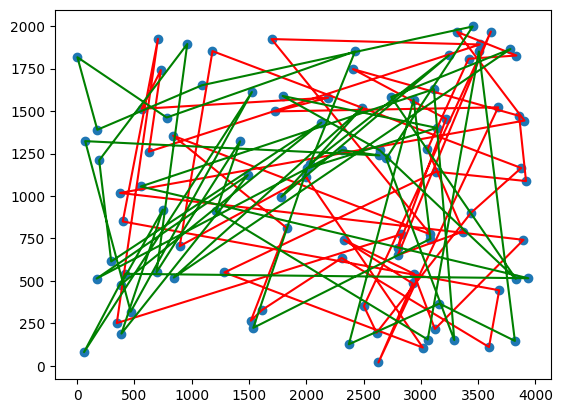

Intance: ./data/lab1/kroB100.txt, best_distance: 140337.7797826241


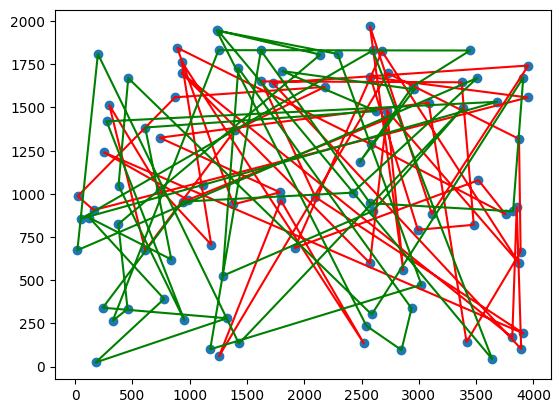

,instance,min_distance,mean_distance,max_distance
0,./data/lab1/kroA100.txt,134930.664266,168949.154324,196511.635838
1,./data/lab1/kroB100.txt,140337.779783,171179.488362,199914.612720


In [59]:
pd.DataFrame(get_results_random_walk())